### Binary Classification - SpamFilter-sm

-Saved as 'distilbert-base-uncased-SpamFilter-sm' on my HuggingFace profile

-Source for the Dataset: https://www.kaggle.com/datasets/datatattle/email-classification-nlp

@article{Sanh2019DistilBERTAD,
  title={DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter},
  author={Victor Sanh and Lysandre Debut and Julien Chaumond and Thomas Wolf},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.01108}
}

#### Import the Necessary Libraries

In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

import torch
from torch.nn.functional import cross_entropy
import torch.nn

from datasets import Dataset, DatasetDict

from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer, AutoModel
from transformers import TrainingArguments, Trainer, AdamW, get_scheduler, set_seed

Versions of Important Libraries Used

In [2]:
print("Pandas:".ljust(18), pd.__version__)
print("NumPy:".ljust(18), np.__version__)
print("Torch:".ljust(18), torch.__version__)

Pandas:            1.4.3
NumPy:             1.22.4
Torch:             1.12.1


#### Basic Constants/Values Used

In [3]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

set_seed(42)

cpu


#### Ingest & Preprocess Data

In [4]:
# training file
train_data = pd.read_csv('/Users/briandunn/Documents/nlpnn/Datasets/Spam Filter Project/SMS_train.csv', encoding='unicode_escape')

# testing file
test_data = pd.read_csv('/Users/briandunn/Documents/nlpnn/Datasets/Spam Filter Project/SMS_test.csv', encoding='unicode_escape')

# Merge the two DataFrames
both_dfs = [train_data, test_data]
data = pd.concat(both_dfs, axis=0, verify_integrity=True, ignore_index=True)
data= data.drop(columns=['S. No.'])
data.rename(columns={'Message_body' : 'text', 'Label' : 'label'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1082 non-null   object
 1   label   1082 non-null   object
dtypes: object(2)
memory usage: 17.0+ KB


#### Visualize Message Length (By Result Type)

label
Non-Spam    884
Spam        198
dtype: int64


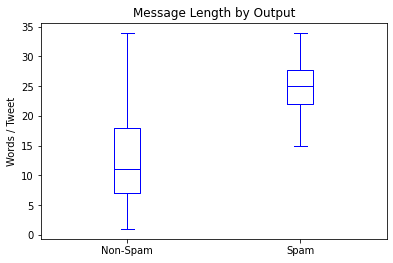

In [5]:
print(data.value_counts('label'))

data['message_len'] = data['text'].str.split().apply(len)
data.boxplot("message_len", by="label", grid=False, showfliers=False, color="Blue")

plt.suptitle('')
plt.title('Message Length by Output')
plt.xlabel('')
plt.ylabel('Words / Tweet')
plt.show()

data = data.drop(columns=['message_len'])


#### Convert String Label to Integer Values

In [6]:
data['label'].replace({'Non-Spam' : 0, 'Spam' : 1}, inplace=True)

#### Convert Pandas DataFrame to Dataset

In [7]:
dataset = Dataset.from_pandas(data)
dataset.shuffle(seed=42)
print(dataset)
print(dataset.features)

Dataset({
    features: ['text', 'label'],
    num_rows: 1082
})
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


#### Split into Train/Test/Valid

In [8]:
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

print("Training dataset shape:", ds['train'].shape)
print("Validation dataset shape:", ds['valid'].shape)
print("Testing dataset shape:", ds['test'].shape)

Training dataset shape: (865, 2)
Validation dataset shape: (108, 2)
Testing dataset shape: (109, 2)


#### Tokenize Entire Dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=128)

encoded_data = ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Print Sample to Ensure Edits Worked as Expected

In [10]:
print(encoded_data['train'].column_names)
print(encoded_data['train'][240])

['text', 'label', 'input_ids', 'attention_mask']
{'text': 'K..then come wenever u lik to come and also tel vikky to come by getting free time..:-)', 'label': 0, 'input_ids': [101, 1047, 1012, 1012, 2059, 2272, 19181, 22507, 1057, 5622, 2243, 2000, 2272, 1998, 2036, 10093, 6819, 19658, 2100, 2000, 2272, 2011, 2893, 2489, 2051, 1012, 1012, 1024, 1011, 1007, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Instantiate Model

In [11]:
num_labels=2
labels_dict = {0 : 'Non-Spam', 1 : 'Spam'}

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

#### Make Sure That git lfs is Installed; Remember to Enter Access Token

In [12]:
# Access Token ...

# Used this the first time to install the git lfs; otherwise, it lets me know that git lfs has been initialized
!git lfs install

Git LFS initialized.


#### Create Function to Compute Metrics

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Instantiate TrainingArguments

In [15]:
batch_size=128
num_of_epochs=3
logging_steps = round(((len(ds['train']) / batch_size)), 0) // 2
model_name = f"{model_ckpt}-SpamFilter-DunnBC22"
learning_rate=2e-5

args = TrainingArguments(output_dir=model_name,
                         num_train_epochs=num_of_epochs,                          
                         per_device_train_batch_size=batch_size, 
                         per_device_eval_batch_size=batch_size, 
                         learning_rate=learning_rate,
                         weight_decay=0.01, 
                         evaluation_strategy="epoch", 
                         disable_tqdm=False,
                         push_to_hub=True, 
                         hub_strategy='every_save',
                         logging_steps=logging_steps,
                         logging_dir='./logs',
                         log_level="error",
                         save_strategy='steps',
                         save_steps=logging_steps,
                         save_total_limit=12,
                         group_by_length=True)

#### Instantiate Optimizer (& Learning Rate Scheduler)

In [16]:
optimizer_name = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_of_epochs * len(ds['train'])

lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer_name,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

optimizer = [optimizer_name, lr_scheduler]

#### Instantiate Trainer

In [17]:
trainer = Trainer(model=model, 
                  args=args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['valid'], 
                  tokenizer=tokenizer, 
                  optimizers=optimizer)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-SpamFilter-DunnBC22 into local empty directory.


#### Train Model

In [18]:
trainer.train()

  0%|          | 0/21 [00:00<?, ?it/s]

{'loss': 0.632, 'learning_rate': 1.9976878612716764e-05, 'epoch': 0.43}
{'loss': 0.5039, 'learning_rate': 1.9953757225433527e-05, 'epoch': 0.86}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.3920164406299591, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.7575757575757576, 'eval_runtime': 23.3405, 'eval_samples_per_second': 4.627, 'eval_steps_per_second': 0.043, 'epoch': 1.0}
{'loss': 0.4048, 'learning_rate': 1.993063583815029e-05, 'epoch': 1.29}
{'loss': 0.3008, 'learning_rate': 1.9907514450867053e-05, 'epoch': 1.71}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.20104406774044037, 'eval_accuracy': 0.9722222222222222, 'eval_f1': 0.971902131018153, 'eval_runtime': 23.1811, 'eval_samples_per_second': 4.659, 'eval_steps_per_second': 0.043, 'epoch': 2.0}
{'loss': 0.2436, 'learning_rate': 1.9884393063583815e-05, 'epoch': 2.14}
{'loss': 0.1536, 'learning_rate': 1.9861271676300578e-05, 'epoch': 2.57}
{'loss': 0.113, 'learning_rate': 1.983815028901734e-05, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.10069987177848816, 'eval_accuracy': 0.9907407407407407, 'eval_f1': 0.9906340436727177, 'eval_runtime': 23.3468, 'eval_samples_per_second': 4.626, 'eval_steps_per_second': 0.043, 'epoch': 3.0}
{'train_runtime': 2295.1556, 'train_samples_per_second': 1.131, 'train_steps_per_second': 0.009, 'train_loss': 0.3359478541782924, 'epoch': 3.0}


TrainOutput(global_step=21, training_loss=0.3359478541782924, metrics={'train_runtime': 2295.1556, 'train_samples_per_second': 1.131, 'train_steps_per_second': 0.009, 'train_loss': 0.3359478541782924, 'epoch': 3.0})

#### Inference Using Fine-Tuned Model

In [19]:
output_predictions = trainer.predict(encoded_data['valid'])

output_predictions.metrics

  0%|          | 0/1 [00:00<?, ?it/s]

{'test_loss': 0.10069987177848816,
 'test_accuracy': 0.9907407407407407,
 'test_f1': 0.9906340436727177,
 'test_runtime': 23.1811,
 'test_samples_per_second': 4.659,
 'test_steps_per_second': 0.043}

#### Create Function to display Confusion Matrix

In [20]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.show()

#### Calculate Baseline Values for Confusion Matrix

In [21]:
tokenizer2 = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=128, return_tensors="np")

encoded_data = ds.map(tokenize, batched=True, batch_size=None)

model2 = (AutoModel.from_pretrained(model_ckpt, num_labels=num_labels, output_hidden_states=True).to(device))

def extract_hidden_states(batch=True):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model2(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

encoded_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

hidden_data = encoded_data.map(extract_hidden_states, batched=True)

X_train = np.array(hidden_data["train"]["hidden_state"])
X_valid = np.array(hidden_data["valid"]["hidden_state"])
y_train = np.array(hidden_data["train"]["label"])
y_valid = np.array(hidden_data["valid"]["label"])
X_train.shape, X_valid.shape

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

((865, 768), (108, 768))

#### Plot Confusion Matrix for Fine-Tuned Model

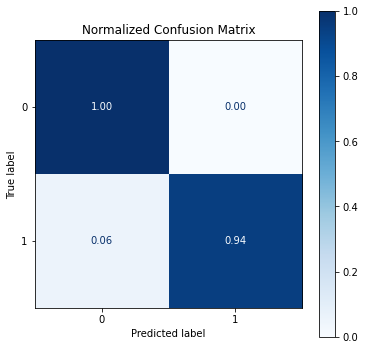

In [22]:
y_preds = np.argmax(output_predictions.predictions, axis=1)
labels = {0 : 'Non-Spam', 1 : 'Spam'}

plot_confusion_matrix(y_preds, y_valid, labels=labels)

#### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [23]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/distilbert-base-uncased-SpamFilter-DunnBC22
   138f8e5..38b16bd  main -> main

